In [320]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np
import mxnet as mx
import logging
from sklearn.metrics import accuracy_score

In [252]:
NUM_NODE = 100
WEIGHT_MIN = .0
WEIGHT_MAX = 1.
OUT_DEGREE_MAX = 10

In [253]:
def generate_rand_weighted_g(node_size=NUM_NODE, p=0.05, directed=True, weight_min=WEIGHT_MIN, weight_max=WEIGHT_MAX):

    rnd_g = nx.erdos_renyi_graph(node_size, p, directed=directed)

    for edge in rnd_g.edges(data=True):
        rnd_g.add_edge(edge[0], edge[1], weight=random.uniform(weight_min, weight_max))
        
    return rnd_g

def print_g(G):
    for edge in G.edges(data=True):
        print(edge)

In [254]:
G = generate_rand_weighted_g(node_size=NUM_NODE)

print_g(G)

(0, 97, {'weight': 0.08358785062925056})
(0, 66, {'weight': 0.7634143565999103})
(0, 69, {'weight': 0.06171691714318861})
(0, 60, {'weight': 0.3316649964909534})
(0, 92, {'weight': 0.7839283177327799})
(0, 31, {'weight': 0.9632729011266646})
(1, 24, {'weight': 0.09722446931430062})
(1, 49, {'weight': 0.627910209934466})
(1, 54, {'weight': 0.8307191854070051})
(1, 30, {'weight': 0.9945325792120301})
(1, 15, {'weight': 0.6436885279401915})
(2, 0, {'weight': 0.7038574513185115})
(2, 82, {'weight': 0.7980743032580668})
(2, 35, {'weight': 0.8227885084945905})
(2, 78, {'weight': 0.2391918641470011})
(3, 33, {'weight': 0.9979970684924421})
(3, 82, {'weight': 0.045943416078371935})
(3, 52, {'weight': 0.2887652376808302})
(3, 89, {'weight': 0.9875421280835874})
(4, 96, {'weight': 0.6515003648286398})
(4, 51, {'weight': 0.14115309810617716})
(4, 66, {'weight': 0.7126841703787815})
(4, 67, {'weight': 0.508778778846733})
(4, 97, {'weight': 0.5841831670839507})
(4, 37, {'weight': 0.9375784744600245

In [256]:
print(G.number_of_nodes())
print(G.number_of_edges())

100
503


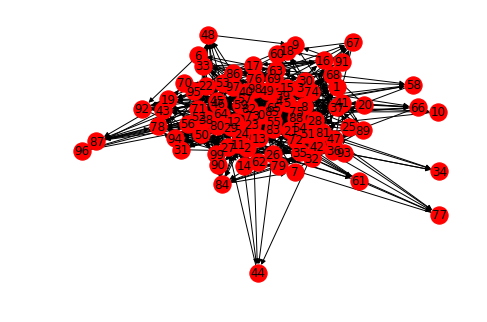

In [257]:
nx.draw(G, with_labels=True)
plt.show()

In [258]:
max_out_degree = max(G.out_degree, key=lambda d: d[1])[1]
max_out_degree

11

In [259]:
X, y = [], []

def one_hot_encode(idx, length=max_out_degree):
    
    ret = np.zeros(length)
    ret[idx] = 1.0
    return ret

for node in G.nodes:
    
    if G.out_degree(node) == 0:
        continue

    init_weight_vec = np.ones(max_out_degree)
    
    for idx, out_edge in enumerate(G.out_edges(node)):
        init_weight_vec[idx] = G.get_edge_data(node, out_edge[1])['weight']
    
    out_neighbors = map(lambda t: (t[1], G.get_edge_data(node, t[1])['weight']),  G.out_edges(node))
#     print(node, min(out_neighbors, key=lambda d: d[1]), len(out_neighbors), sorted(out_neighbors))
    
#     label = one_hot_encode(np.argmin(init_weight_vec, axis=0))
    label = min(out_neighbors, key=lambda d: d[1])[1]
#     print(label, init_weight_vec[np.argmin(init_weight_vec)])
    assert label == init_weight_vec[np.argmin(init_weight_vec)]
    X.append(init_weight_vec)
    y.append(label)
    
features = np.array(X)
labels = np.array(y)

In [260]:
print(X[0])
print(y[0])

[ 0.08358785  0.76341436  0.06171692  0.331665    0.78392832  0.9632729   1.
  1.          1.          1.          1.        ]
0.0617169171432


In [261]:
def augment_dataset(X, y=None, augmentation_index=10):
    
    X_aug, y_aug = [], []
    indices = np.arange(len(X[0]))
    
    for idx, x in enumerate(X):
        for _ in range(augmentation_index):
            np.random.shuffle(indices)
            X_aug.append(x[indices])
            y_aug.append(one_hot_encode(np.argmin(x[indices])))
    
    return np.array(X_aug), np.array(y_aug)

In [262]:
X_aug, y_aug = augment_dataset(features, labels, augmentation_index=100)
print(X_aug.shape)
print(y_aug.shape)

(10000, 11)
(10000, 11)


In [263]:
print(X_aug[1])
print(y_aug[1])

[ 1.          0.76341436  0.78392832  0.331665    0.08358785  1.
  0.06171692  1.          1.          0.9632729   1.        ]
[ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]


In [264]:
indices = np.arange(len(X_aug))
np.random.shuffle(indices)
X, y =  X_aug[indices], y_aug[indices]
print(X.shape)
print(y.shape)

(10000, 11)
(10000, 11)


In [265]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.95, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(9500, 11)
(9500, 11)
(500, 11)
(500, 11)


In [345]:
batch_size = 50

train_iter = mx.io.NDArrayIter(X_train, y_train, batch_size, shuffle=True)
val_iter = mx.io.NDArrayIter(X_test, y_test, batch_size=len(y_test))

In [346]:
def build_model(context=mx.gpu()):
    
    data = mx.sym.var('data')
    label = mx.sym.var('softmax_label')
    
    fc2  = mx.sym.FullyConnected(data=data, num_hidden=32)
    fc2 = mx.sym.Activation(data=fc2, act_type="relu")
    
    fc3  = mx.sym.FullyConnected(data=fc2, num_hidden=max_out_degree)
    mlp  = mx.sym.SoftmaxOutput(data=fc3, label=label)
    
    return mx.mod.Module(symbol=mlp, context=context)

In [390]:
logging.getLogger().setLevel(logging.DEBUG)  # logging to stdout
model = build_model()
model.bind(data_shapes=train_iter.provide_data, label_shapes=train_iter.provide_label)
model.init_params()

In [406]:
def custom_acc(label, pred):
    tmp_label = np.argmax(label, axis=1)
    tmp_pred = np.argmax(pred, axis=1)
    return accuracy_score(tmp_label, tmp_pred)

custom_metric = mx.metric.create(custom_acc)
type(custom_metric)

mxnet.metric.CustomMetric

In [407]:
model.fit(train_iter,  # train data
              eval_data=val_iter,  # validation data
              optimizer='adam',  # use SGD to train
#               optimizer_params={'learning_rate':0.01, 'momentum': 0.9},
              eval_metric=custom_metric,  # report accuracy during training
              batch_end_callback = mx.callback.Speedometer(batch_size, 10), # output progress for each 100 data batches
              num_epoch=1)  # train for at most 10 dataset passes

INFO:root:Epoch[0] Batch [10]	Speed: 8385.46 samples/sec	custom_acc=0.763636
INFO:root:Epoch[0] Batch [20]	Speed: 9561.85 samples/sec	custom_acc=0.796000
INFO:root:Epoch[0] Batch [30]	Speed: 8079.89 samples/sec	custom_acc=0.774000


(50, 11)
(50, 11)
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
[ 0.02151103  0.03453143  0.33251575  0.0283916   0.03848531  0.03856419
  0.02248814  0.01405803  0.0447601   0.29555887  0.12913558]
(50,)
(50,)
(50, 11)
(50, 11)
[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.08707231  0.12904115  0.09030928  0.11576632  0.10798962  0.12890346
  0.08481145  0.04684506  0.12948559  0.05867933  0.02109645]
(50,)
(50,)
(50, 11)
(50, 11)
[ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
[ 0.01335795  0.1776246   0.00405538  0.02262024  0.34838921  0.03833192
  0.0128564   0.01055077  0.32938254  0.03952764  0.00330336]
(50,)
(50,)
(50, 11)
(50, 11)
[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.04086236  0.88660699  0.00422214  0.02300427  0.00229784  0.02307149
  0.00317704  0.00624781  0.00554153  0.0032817   0.00168676]
(50,)
(50,)
(50, 11)
(50, 11)
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
[ 0.00675079  0.00667747  0.04902602  0.00616194  0.0435187   0.00484495
  0.00573528  0.006

INFO:root:Epoch[0] Batch [40]	Speed: 8105.31 samples/sec	custom_acc=0.770000
INFO:root:Epoch[0] Batch [50]	Speed: 9182.93 samples/sec	custom_acc=0.808000
INFO:root:Epoch[0] Batch [60]	Speed: 9147.92 samples/sec	custom_acc=0.800000


(50, 11)
(50, 11)
[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
[ 0.00092464  0.02266017  0.54614156  0.00777764  0.00230963  0.0013257
  0.00132947  0.16130739  0.00914891  0.00170441  0.24537051]
(50,)
(50,)
(50, 11)
(50, 11)
[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[  1.79691939e-04   4.66742665e-01   3.32405383e-04   3.61014307e-01
   5.97319147e-03   3.24217544e-04   6.71888585e-04   6.37801439e-02
   3.05426195e-02   7.01539218e-02   2.84842186e-04]
(50,)
(50,)
(50, 11)
(50, 11)
[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
[ 0.00204984  0.0069528   0.05822364  0.00114235  0.02312662  0.84347624
  0.00494774  0.00458279  0.00675375  0.00821516  0.04052909]
(50,)
(50,)
(50, 11)
(50, 11)
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
[  1.70196334e-04   5.86003473e-04   1.00352324e-03   6.79747318e-04
   8.95948033e-04   3.71310720e-03   3.75973235e-04   2.22664187e-03
   2.18558222e-01   2.27618858e-01   5.44171691e-01]
(50,)
(50,)
(50, 11)
(50, 11)
[ 0.  0.  0.  0.  0.  0.  0

INFO:root:Epoch[0] Batch [70]	Speed: 9003.63 samples/sec	custom_acc=0.842000
INFO:root:Epoch[0] Batch [80]	Speed: 9638.93 samples/sec	custom_acc=0.784000
INFO:root:Epoch[0] Batch [90]	Speed: 8691.27 samples/sec	custom_acc=0.830000
INFO:root:Epoch[0] Batch [100]	Speed: 8888.72 samples/sec	custom_acc=0.858000


[ 0.00233932  0.0034664   0.00363555  0.00403261  0.00360976  0.76168948
  0.18460611  0.00224178  0.01392836  0.00784504  0.01260559]
(50,)
(50,)
(50, 11)
(50, 11)
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
[  2.68361550e-02   7.38735544e-04   2.12120079e-03   6.99625611e-02
   7.56512512e-04   2.60039378e-04   1.96564884e-04   9.71378002e-04
   2.36587203e-03   1.98813202e-03   8.93802881e-01]
(50,)
(50,)
(50, 11)
(50, 11)
[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[  1.09402172e-03   8.36069524e-01   5.69684058e-02   2.25742720e-03
   1.94464825e-04   8.23262744e-05   8.81491796e-05   1.02046929e-01
   3.25953471e-04   5.71029668e-04   3.01832799e-04]
(50,)
(50,)
(50, 11)
(50, 11)
[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
[  3.70397326e-03   1.14871342e-04   5.64764232e-05   4.75426810e-03
   4.70222570e-02   1.06589613e-03   4.21369635e-02   4.04591323e-04
   8.02548766e-01   9.81328487e-02   5.90601448e-05]
(50,)
(50,)
(50, 11)
(50, 11)
[ 0.  0.  0.  0.  0.  0.  0.  0.  

INFO:root:Epoch[0] Batch [110]	Speed: 8103.46 samples/sec	custom_acc=0.822000
INFO:root:Epoch[0] Batch [120]	Speed: 8705.96 samples/sec	custom_acc=0.846000
INFO:root:Epoch[0] Batch [130]	Speed: 8422.74 samples/sec	custom_acc=0.846000


(50, 11)
(50, 11)
[ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
[ 0.02856068  0.02312733  0.02494316  0.03653067  0.03087211  0.06387647
  0.668262    0.05420296  0.02382338  0.00918883  0.03661235]
(50,)
(50,)
(50, 11)
(50, 11)
[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
[  5.55983395e-04   8.03522416e-04   4.95114422e-04   9.92475212e-01
   7.35397392e-04   1.08163455e-03   7.73908512e-04   1.44745945e-03
   9.55982134e-04   2.35738989e-04   4.40052361e-04]
(50,)
(50,)
(50, 11)
(50, 11)
[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
[  1.14439783e-04   2.16761529e-01   6.48469245e-03   3.27196747e-01
   2.40171119e-03   2.52233760e-04   1.58203930e-01   2.21499329e-04
   2.21958950e-01   6.63517937e-02   5.24151365e-05]
(50,)
(50,)
(50, 11)
(50, 11)
[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
[  2.59172899e-04   2.56917527e-04   8.58285785e-01   2.34935243e-04
   9.37515274e-02   5.33230021e-04   3.63058847e-04   2.81630986e-04
   8.19195248e-03   1.54474713e-02   2.23943181e-02]


INFO:root:Epoch[0] Batch [140]	Speed: 8397.85 samples/sec	custom_acc=0.856000
INFO:root:Epoch[0] Batch [150]	Speed: 8723.56 samples/sec	custom_acc=0.864000
INFO:root:Epoch[0] Batch [160]	Speed: 9794.28 samples/sec	custom_acc=0.854000


(50, 11)
(50, 11)
[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
[  2.43805379e-01   1.72962478e-04   5.84866583e-01   2.12676896e-04
   3.55469761e-04   4.24251053e-03   1.00653581e-01   5.27798682e-02
   1.95866043e-04   1.37978757e-04   1.25771705e-02]
(50,)
(50,)
(50, 11)
(50, 11)
[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
[  3.42174084e-04   1.16489723e-03   4.42153105e-04   1.43038575e-04
   1.33451787e-04   1.46555738e-03   6.83770486e-05   4.12553519e-01
   4.52370936e-04   3.59399244e-02   5.47294557e-01]
(50,)
(50,)
(50, 11)
(50, 11)
[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
[ 0.12396766  0.12546702  0.12163128  0.05727961  0.13543175  0.14606434
  0.03811457  0.05482624  0.05373389  0.04362092  0.0998627 ]
(50,)
(50,)
(50, 11)
(50, 11)
[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
[  2.35789316e-03   5.09576756e-04   1.05485301e-02   5.65388978e-01
   1.30995316e-03   3.41022213e-04   3.83523017e-01   3.46666574e-02
   7.99383342e-05   8.02622308e-05   1.19422376e-03]


INFO:root:Epoch[0] Batch [170]	Speed: 8769.34 samples/sec	custom_acc=0.862000
INFO:root:Epoch[0] Train-custom_acc=0.848889
INFO:root:Epoch[0] Time cost=1.071
INFO:root:Epoch[0] Validation-custom_acc=0.828000


[  4.93064746e-02   2.71769182e-04   1.14741288e-02   3.16103135e-04
   2.40999070e-04   2.17700202e-04   5.11959835e-04   1.06072905e-04
   5.08156023e-04   9.36906576e-01   1.40114702e-04]
(50,)
(50,)
(50, 11)
(50, 11)
[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
[  3.87030141e-03   5.12684649e-03   3.97585519e-03   2.35669129e-02
   1.13391737e-03   1.03746401e-03   1.35003717e-03   9.55277860e-01
   1.60470395e-03   2.31177430e-03   7.44391931e-04]
(50,)
(50,)
(50, 11)
(50, 11)
[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
[  2.75547180e-04   3.21933534e-04   1.63288370e-01   1.20728080e-04
   9.91804336e-05   9.82575220e-05   2.36121893e-01   4.72567499e-01
   1.26965582e-01   6.94748378e-05   7.15625865e-05]
(50,)
(50,)
(50, 11)
(50, 11)
[ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
[  4.99743364e-05   5.26929914e-04   5.34487784e-01   2.54485360e-03
   1.86106026e-01   4.58462425e-02   1.74453869e-01   2.40477044e-02
   3.19026187e-02   1.81531450e-05   1.58045805e-05]
(50,)
(5

In [393]:
pred = np.argmax(model.predict(val_iter).asnumpy(), axis=1)
accuracy_score(np.argmax(y_test, axis=1)[:], pred[:])

0.71399999999999997